In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import torch
from torch import nn
from easy_tpp.preprocess.event_tokenizer import EventTokenizer
from easy_tpp.config_factory import DataSpecConfig
from models.encoders.gru import GRUTPPEncoder
from models.decoders.rmtpp import RMTPPDecoder, RMTPPLoss
from models import TPPModel, VAETPPModel
from torch.utils.data import DataLoader, Dataset
from utils.evaluatetpp import evaluate_tpp_model, evaluate_vae_model, calculate_event_metrics
from scipy import integrate

import scienceplots
plt.style.use(['science'])

# font sizes
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'axes.labelsize': 18})
plt.rcParams.update({'legend.fontsize': 16})

In [47]:
def preprocess_data(raw_data):
    # Validate input
    if not raw_data:
        raise ValueError("Input data is empty")
        
    # Create input data dictionary
    input_data = {
        'time_seqs': [[x["time_since_start"] for x in seq] for seq in raw_data],
        'type_seqs': [[x["type_event"] for x in seq] for seq in raw_data],
        'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in raw_data]
    }

    filtered_data = {
        k: [seq for seq in v if len(seq) > 0]
        for k, v in input_data.items()
    }
    
    if not filtered_data['type_seqs']:
        raise ValueError("No valid sequences found after filtering (all sequences were empty)")
        
    return filtered_data

def collate_fn(batch, config):
    tokenizer = EventTokenizer(config)
    tokenizer.padding_side = 'right'
    seq_lengths = [batch_item['sequence_length'] for batch_item in batch]  
    padded_batch = tokenizer.pad(batch, 
                                 return_tensors='pt',
                                 return_attention_mask=None,
                                 padding='longest')
    padded_batch['sequence_length'] = torch.tensor(seq_lengths)
    
    return padded_batch

In [48]:
class EventDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['type_seqs'])

    def __getitem__(self, idx):
        return {
            'time_seqs': self.data['time_seqs'][idx],
            'type_seqs': self.data['type_seqs'][idx],
            'time_delta_seqs': self.data['time_delta_seqs'][idx],
            'sequence_length': len(self.data['type_seqs'][idx])
        }

In [49]:
def plot_event_sequence(time_seqs, type_seqs, time_delta_seqs, sequence_length, calculated_deltas, decoder_output, num_samples=5, file_name=None):
    fig, axs = plt.subplots(num_samples, 2, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        time_seq = time_seqs[i].detach().cpu().numpy()
        type_seq = type_seqs[i].detach().cpu().numpy()
        time_delta_seq = time_delta_seqs[i].detach().cpu().numpy()
        seq_len = sequence_length[i].item()
        pred_time_delta_seq = calculated_deltas[i].detach().cpu().numpy() if isinstance(calculated_deltas, torch.Tensor) else calculated_deltas
        pred_mark_logits = decoder_output.mark_logits[i].detach().cpu().numpy()

        axs[i, 0].plot(time_seq[:seq_len], type_seq[:seq_len], 'o-', label='True')
        axs[i, 0].plot(time_seq[:seq_len], np.argmax(pred_mark_logits[:seq_len], axis=-1), 'o-', label='Predicted')
        axs[i, 0].set_xlabel('Time')
        axs[i, 0].set_ylabel('Event Type')
        axs[i, 0].set_title(f'Sample {i+1} - Event Sequence')
        axs[i, 0].legend()

        axs[i, 1].plot(time_seq[:seq_len], time_delta_seq[:seq_len], 'o-', label='True')
        axs[i, 1].plot(time_seq[:seq_len], pred_time_delta_seq[:seq_len], 'o-', label='Calculated')
        axs[i, 1].set_xlabel('Time')
        axs[i, 1].set_ylabel('Time Delta')
        axs[i, 1].set_title(f'Sample {i+1} - Time Delta Sequence')
        axs[i, 1].legend()

    plt.tight_layout()
    plt.savefig(file_name) if file_name else plt.show()


In [50]:
dev_dict = pkl.load(open('data/taxi/dev.pkl', 'rb'))
test_dict = pkl.load(open('data/taxi/test.pkl', 'rb'))
train_dict = pkl.load(open('data/taxi/train.pkl', 'rb'))

train_data = train_dict['train']
test_data = test_dict['test']
dev_data = dev_dict['dev']

In [51]:
dim_process = train_dict['dim_process']
config = DataSpecConfig.parse_from_yaml_config({
    'num_event_types': dim_process,
    'pad_token_id': dim_process
})

In [52]:
# Create datasets
preprocessed_train = preprocess_data(train_data)
preprocessed_test = preprocess_data(test_data)

train_dataset = EventDataset(preprocessed_train)
test_dataset = EventDataset(preprocessed_test)

# Create data loaders with collate function and arguments to prepare_data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)

In [53]:
HIDDEN_DIM = 128
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

tpp_model = TPPModel(config, hidden_dim=HIDDEN_DIM, mlp_dim=MLP_DIM, device=device).to(device)

# Training loop
num_epochs = 200
optimizer = torch.optim.Adam(tpp_model.parameters(), lr=0.001)

# load the model
try:
    tpp_model.load_state_dict(torch.load('models/tpp_model.pt'))
    print("Model loaded successfully, skipping training.")
except FileNotFoundError:
    print("Model not found, starting training from scratch.")

    for epoch in range(num_epochs):
        tpp_model.train()
        total_train_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            decoder_output = tpp_model(batch)
            time_loss, mark_loss, total_loss = tpp_model.compute_loss(batch, decoder_output)
            total_loss.backward()
            optimizer.step()
            total_train_loss += total_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Evaluate on test data
        tpp_model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                decoder_output = tpp_model(batch)
                _, _, total_loss = tpp_model.compute_loss(batch, decoder_output)
                total_test_loss += total_loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")

Model loaded successfully, skipping training.


/tmp/ipykernel_2231418/3761076854.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tpp_model.load_state_dict(torch.load('models/tpp_model.pt'))


In [54]:
# save model
torch.save(tpp_model.state_dict(), 'models/tpp_model.pt')

In [55]:
tpp_eval_metrics = evaluate_tpp_model(tpp_model, test_loader, config, device=device)

/home/jy384/projects/ProbabilisticTPP/utils/evaluatetpp.py:97: RuntimeWarning: overflow encountered in exp
  - np.exp(


In [56]:
tpp_eval_metrics

{'time_mae': 0.029474146958103235,
 'time_rmse': 0.040391199509499404,
 'event_accuracy': 0.9997975708502024,
 'event_total': 14820,
 'type_metrics': {'type_0': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_1': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_2': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_3': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_4': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_5': {'precision': 0.9982014388489209,
   'recall': 1.0,
   'f1': 0.9990999099909991},
  'type_6': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
  'type_7': {'precision': 0.6, 'recall': 1.0, 'f1': 0.7499999999999999},
  'type_8': {'precision': 1.0,
   'recall': 0.9998495788206979,
   'f1': 0.9999247837532907},
  'type_9': {'precision': 0, 'recall': 0.0, 'f1': 0}},
 'predicted_intervals': [0.0,
  0.23916255989031157,
  0.18408568673973025,
  0.06388621357011703,
  0.024077992854057984,
  0.12980049273478944,
  0.09194196579586866,
  0.13207943224337

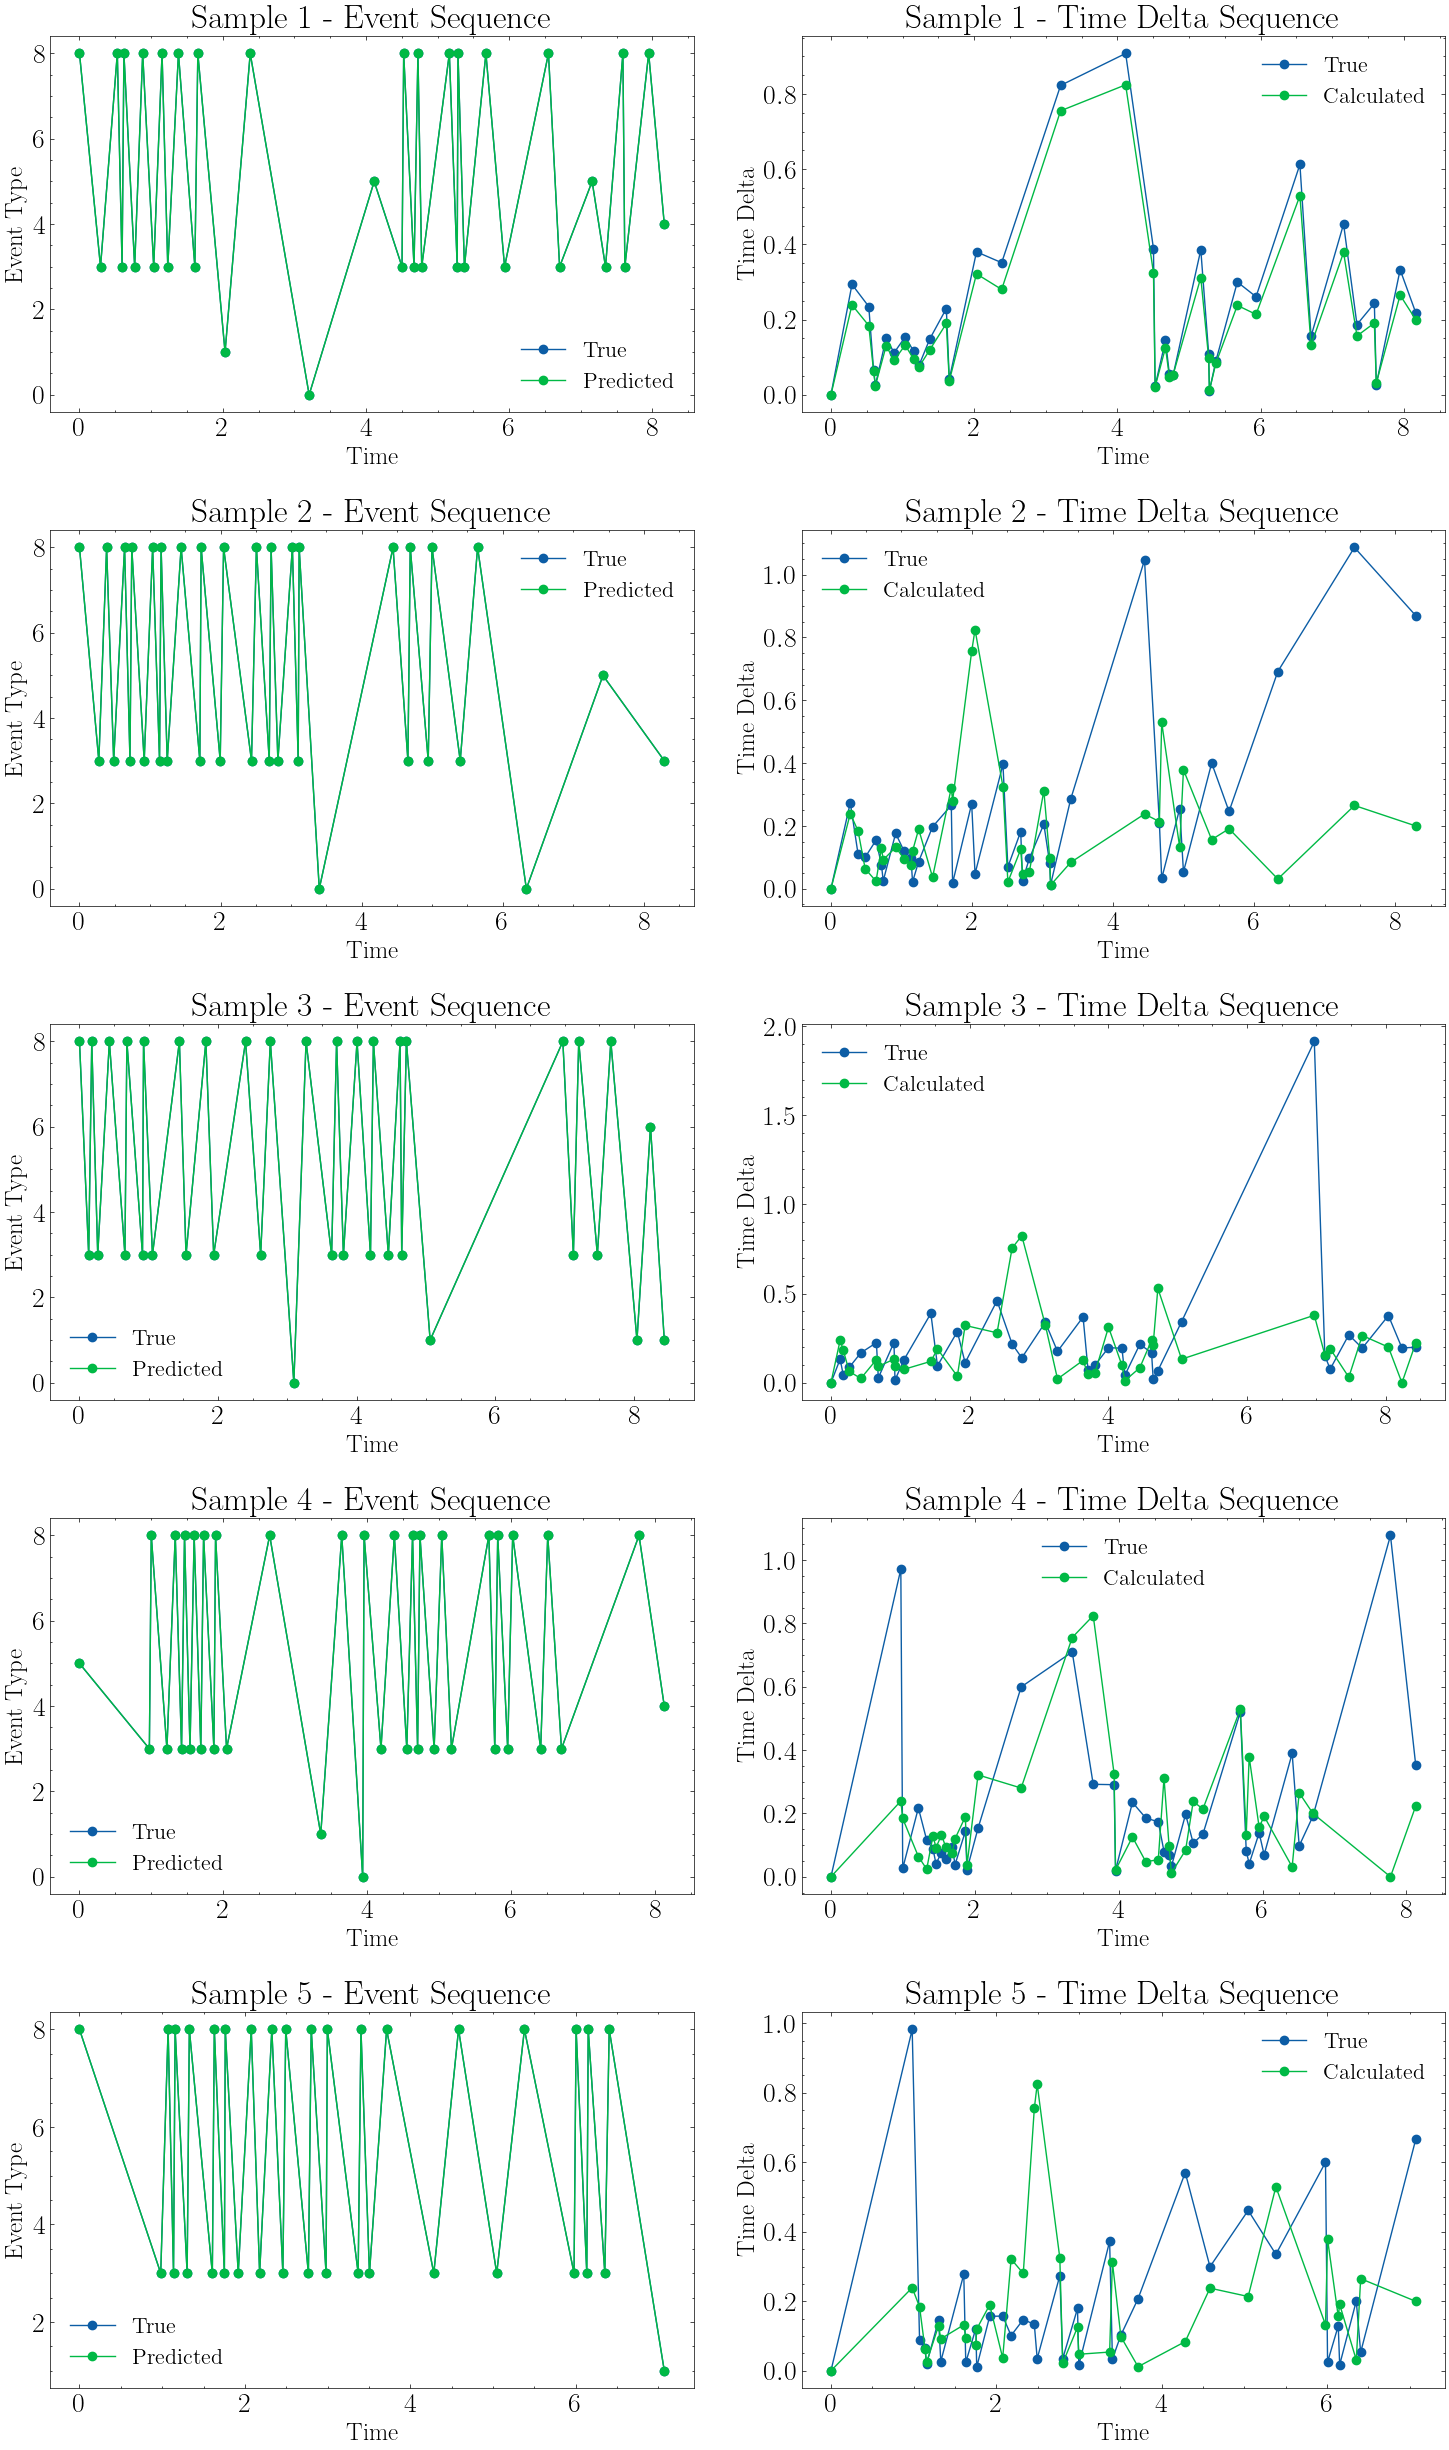

In [57]:
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    decoder_output = tpp_model(batch)
    plot_event_sequence(
        batch['time_seqs'], 
        batch['type_seqs'], 
        batch['time_delta_seqs'], 
        batch['sequence_length'], 
        tpp_eval_metrics['predicted_intervals'], 
        decoder_output,
        file_name='tpp_event_sequence.png'
    )
    break

In [58]:
# reload VAETPPModel
import importlib
import models
importlib.reload(models)
from models import TPPModel, VAETPPModel

HIDDEN_DIM = 128
LATENT_DIM = 32
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

# calculate the number of steps for beta annealing and warmup
num_epochs = 200
num_steps = len(train_loader) * num_epochs
cyclic_steps = num_steps // 5
warmup_steps = len(train_loader) * 20

vae_model = VAETPPModel(config, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, mlp_dim=MLP_DIM, device=device, beta_steps=num_steps, warmup_steps=warmup_steps, beta_start=0, beta_end=0.5, l1_lambda=0.000, l2_lambda=0.000).to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)

# One cycle learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    anneal_strategy='cos',
)

# try loading the model
try:
    vae_model.load_state_dict(torch.load('models/vae_model.pt'))
    print("Model loaded successfully, skipping training.")
except FileNotFoundError:
    print("Model not found, starting training from scratch.")

    # Training loop with beta annealing
    for epoch in range(num_epochs):
        vae_model.train()
        total_train_loss = 0
        for step, batch in enumerate(train_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            decoder_output = vae_model(batch)
            time_loss, mark_loss, total_loss = vae_model.compute_loss(batch, decoder_output)
            total_loss.backward()
            optimizer.step()
            scheduler.step()
            total_train_loss += total_loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        vae_model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                decoder_output = vae_model(batch)
                _, _, total_loss = vae_model.compute_loss(batch, decoder_output)
                total_test_loss += total_loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")


Model loaded successfully, skipping training.


/tmp/ipykernel_2231418/551862181.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('models/vae_model.pt'))


In [59]:
# save model
torch.save(vae_model.state_dict(), 'models/vae_model.pt')

In [60]:
vae_eval_metrics = evaluate_vae_model(vae_model, test_loader, config, device=device)

/home/jy384/projects/ProbabilisticTPP/utils/evaluatetpp.py:238: RuntimeWarning: overflow encountered in exp
  - np.exp(


In [61]:
# vae_eval_metrics

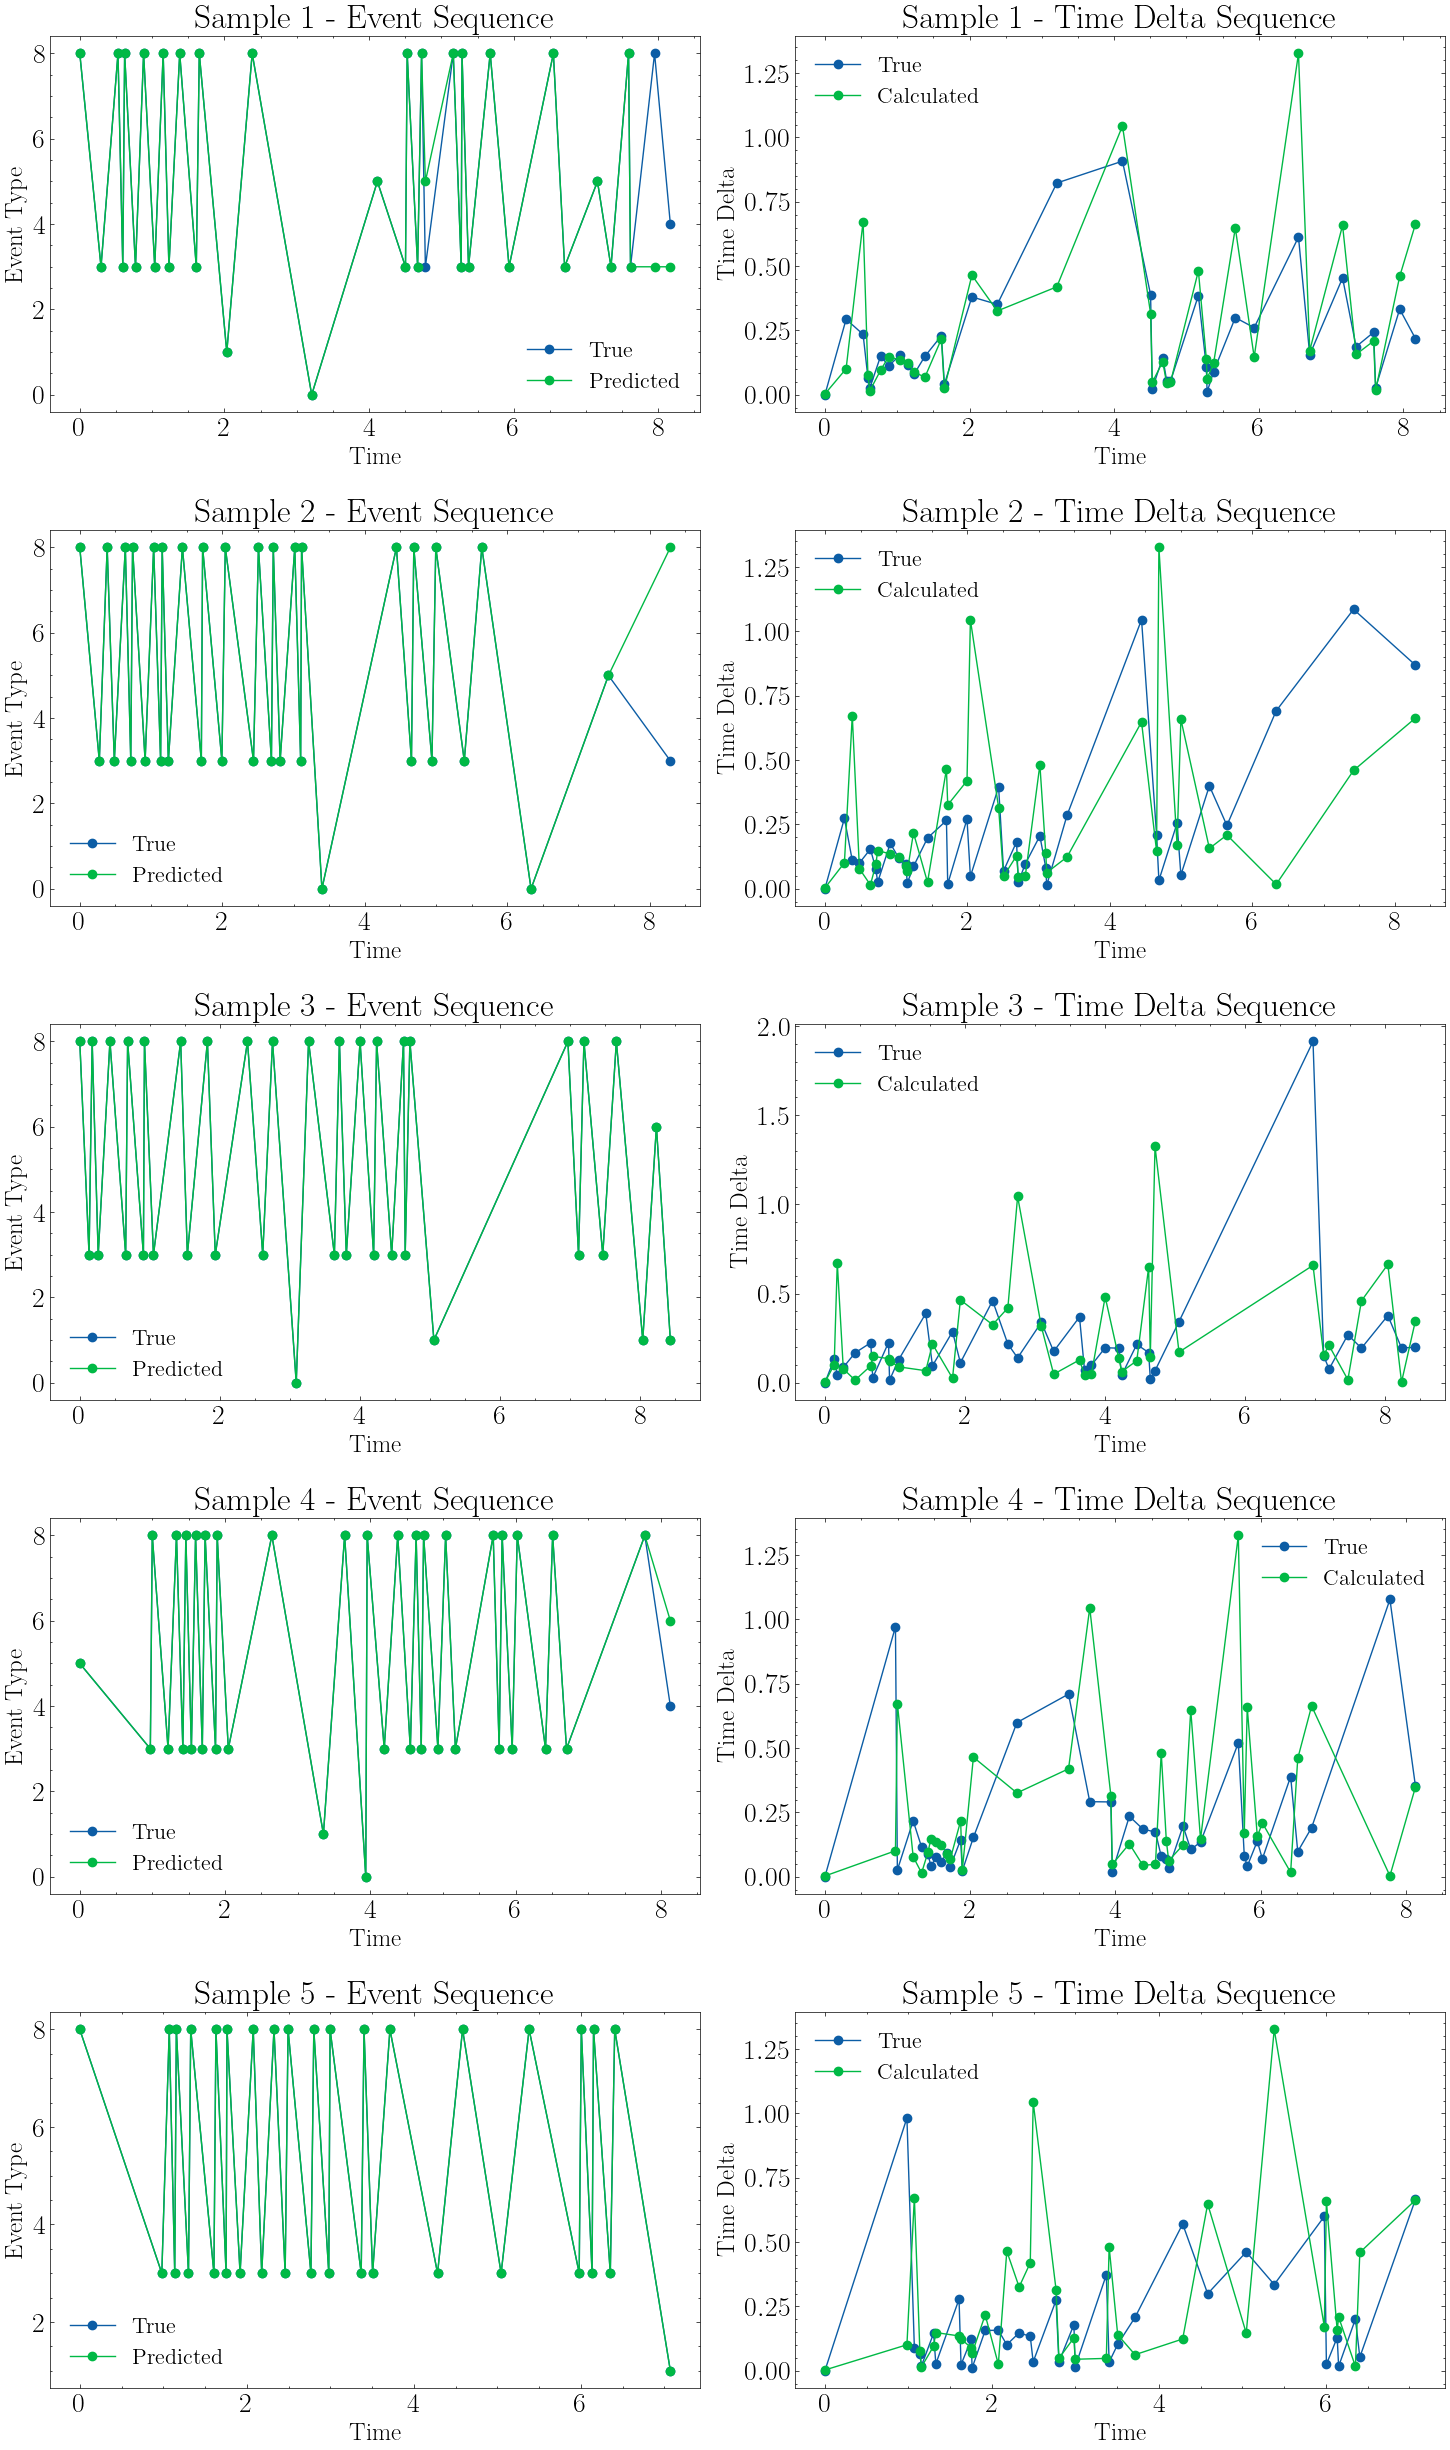

In [62]:
# plot the event sequences and the predicted event sequences
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    decoder_output = vae_model(batch)
    plot_event_sequence(
        batch['time_seqs'], 
        batch['type_seqs'], 
        batch['time_delta_seqs'], 
        batch['sequence_length'], 
        vae_eval_metrics['predicted_intervals'], 
        decoder_output,
        file_name='vae_event_sequence.png'
    )
    break

In [63]:
def plot_event_sequence_both(
    time_seqs,
    type_seqs,
    time_delta_seqs,
    sequence_length,
    tpp_eval_metrics,
    vae_eval_metrics,
    decoder_output_tpp,
    decoder_output_vae,
    num_samples=5,
    file_name=None,
):
    """
    Plot event sequences and compare deterministic vs probabilistic intensity functions.

    Args:
        time_seqs (torch.Tensor): Ground truth event times.
        type_seqs (torch.Tensor): Ground truth event types.
        time_delta_seqs (torch.Tensor): Ground truth time deltas.
        sequence_length (torch.Tensor): Sequence lengths.
        tpp_eval_metrics (dict): Evaluation metrics from the TPP model.
        vae_eval_metrics (dict): Evaluation metrics from the VAE model.
        decoder_output_tpp (object): Decoder output from TPP model.
        decoder_output_vae (object): Decoder output from VAE model.
        num_samples (int): Number of sequences to plot.
    """
    predicted_intervals_tpp = tpp_eval_metrics["predicted_intervals"]
    predicted_intervals_vae = vae_eval_metrics["predicted_intervals"]

    fig, axes = plt.subplots(num_samples, 2, figsize=(18, 5 * num_samples))

    for i in range(num_samples):
        time_seq = time_seqs[i].detach().cpu().numpy()
        type_seq = type_seqs[i].detach().cpu().numpy()
        time_delta_seq = time_delta_seqs[i].detach().cpu().numpy()
        seq_len = sequence_length[i].item()

        pred_time_delta_tpp = (
            predicted_intervals_tpp[i].detach().cpu().numpy()
            if isinstance(predicted_intervals_tpp, torch.Tensor)
            else predicted_intervals_tpp
        )
        pred_time_delta_vae = (
            predicted_intervals_vae[i].detach().cpu().numpy()
            if isinstance(predicted_intervals_vae, torch.Tensor)
            else predicted_intervals_vae
        )

        pred_event_types_tpp = torch.argmax(decoder_output_tpp.mark_logits[i], dim=-1).detach().cpu().numpy()
        pred_event_types_vae = torch.argmax(decoder_output_vae.mark_logits[i], dim=-1).detach().cpu().numpy()

        axes[i, 0].plot(time_seq[:seq_len], type_seq[:seq_len], "o-", label="True")
        axes[i, 0].plot(
            time_seq[:seq_len],
            pred_event_types_tpp[:seq_len],
            "o-",
            label="TPP Predicted",
        )
        axes[i, 0].plot(
            time_seq[:seq_len],
            pred_event_types_vae[:seq_len],
            "o-",
            label="VAE Predicted",
        )
        axes[i, 0].set_xlabel("Time")
        axes[i, 0].set_ylabel("Event Type")
        axes[i, 0].set_title(f"Event Sequence {i+1}")
        axes[i, 0].legend()

        axes[i, 1].plot(time_seq[:seq_len], time_delta_seq[:seq_len], "o-", label="True")
        axes[i, 1].plot(
            time_seq[:seq_len],
            pred_time_delta_tpp[:seq_len],
            "o-",
            label="TPP Predicted",
        )
        axes[i, 1].plot(
            time_seq[:seq_len],
            pred_time_delta_vae[:seq_len],
            "o-",
            label="VAE Predicted",
        )
        axes[i, 1].set_xlabel("Time")
        axes[i, 1].set_ylabel("Time Delta")
        axes[i, 1].set_title(f"Time Delta Sequence {i+1}")
        axes[i, 1].legend()

    plt.tight_layout()
    if file_name:
        plt.savefig(file_name)
    plt.show()


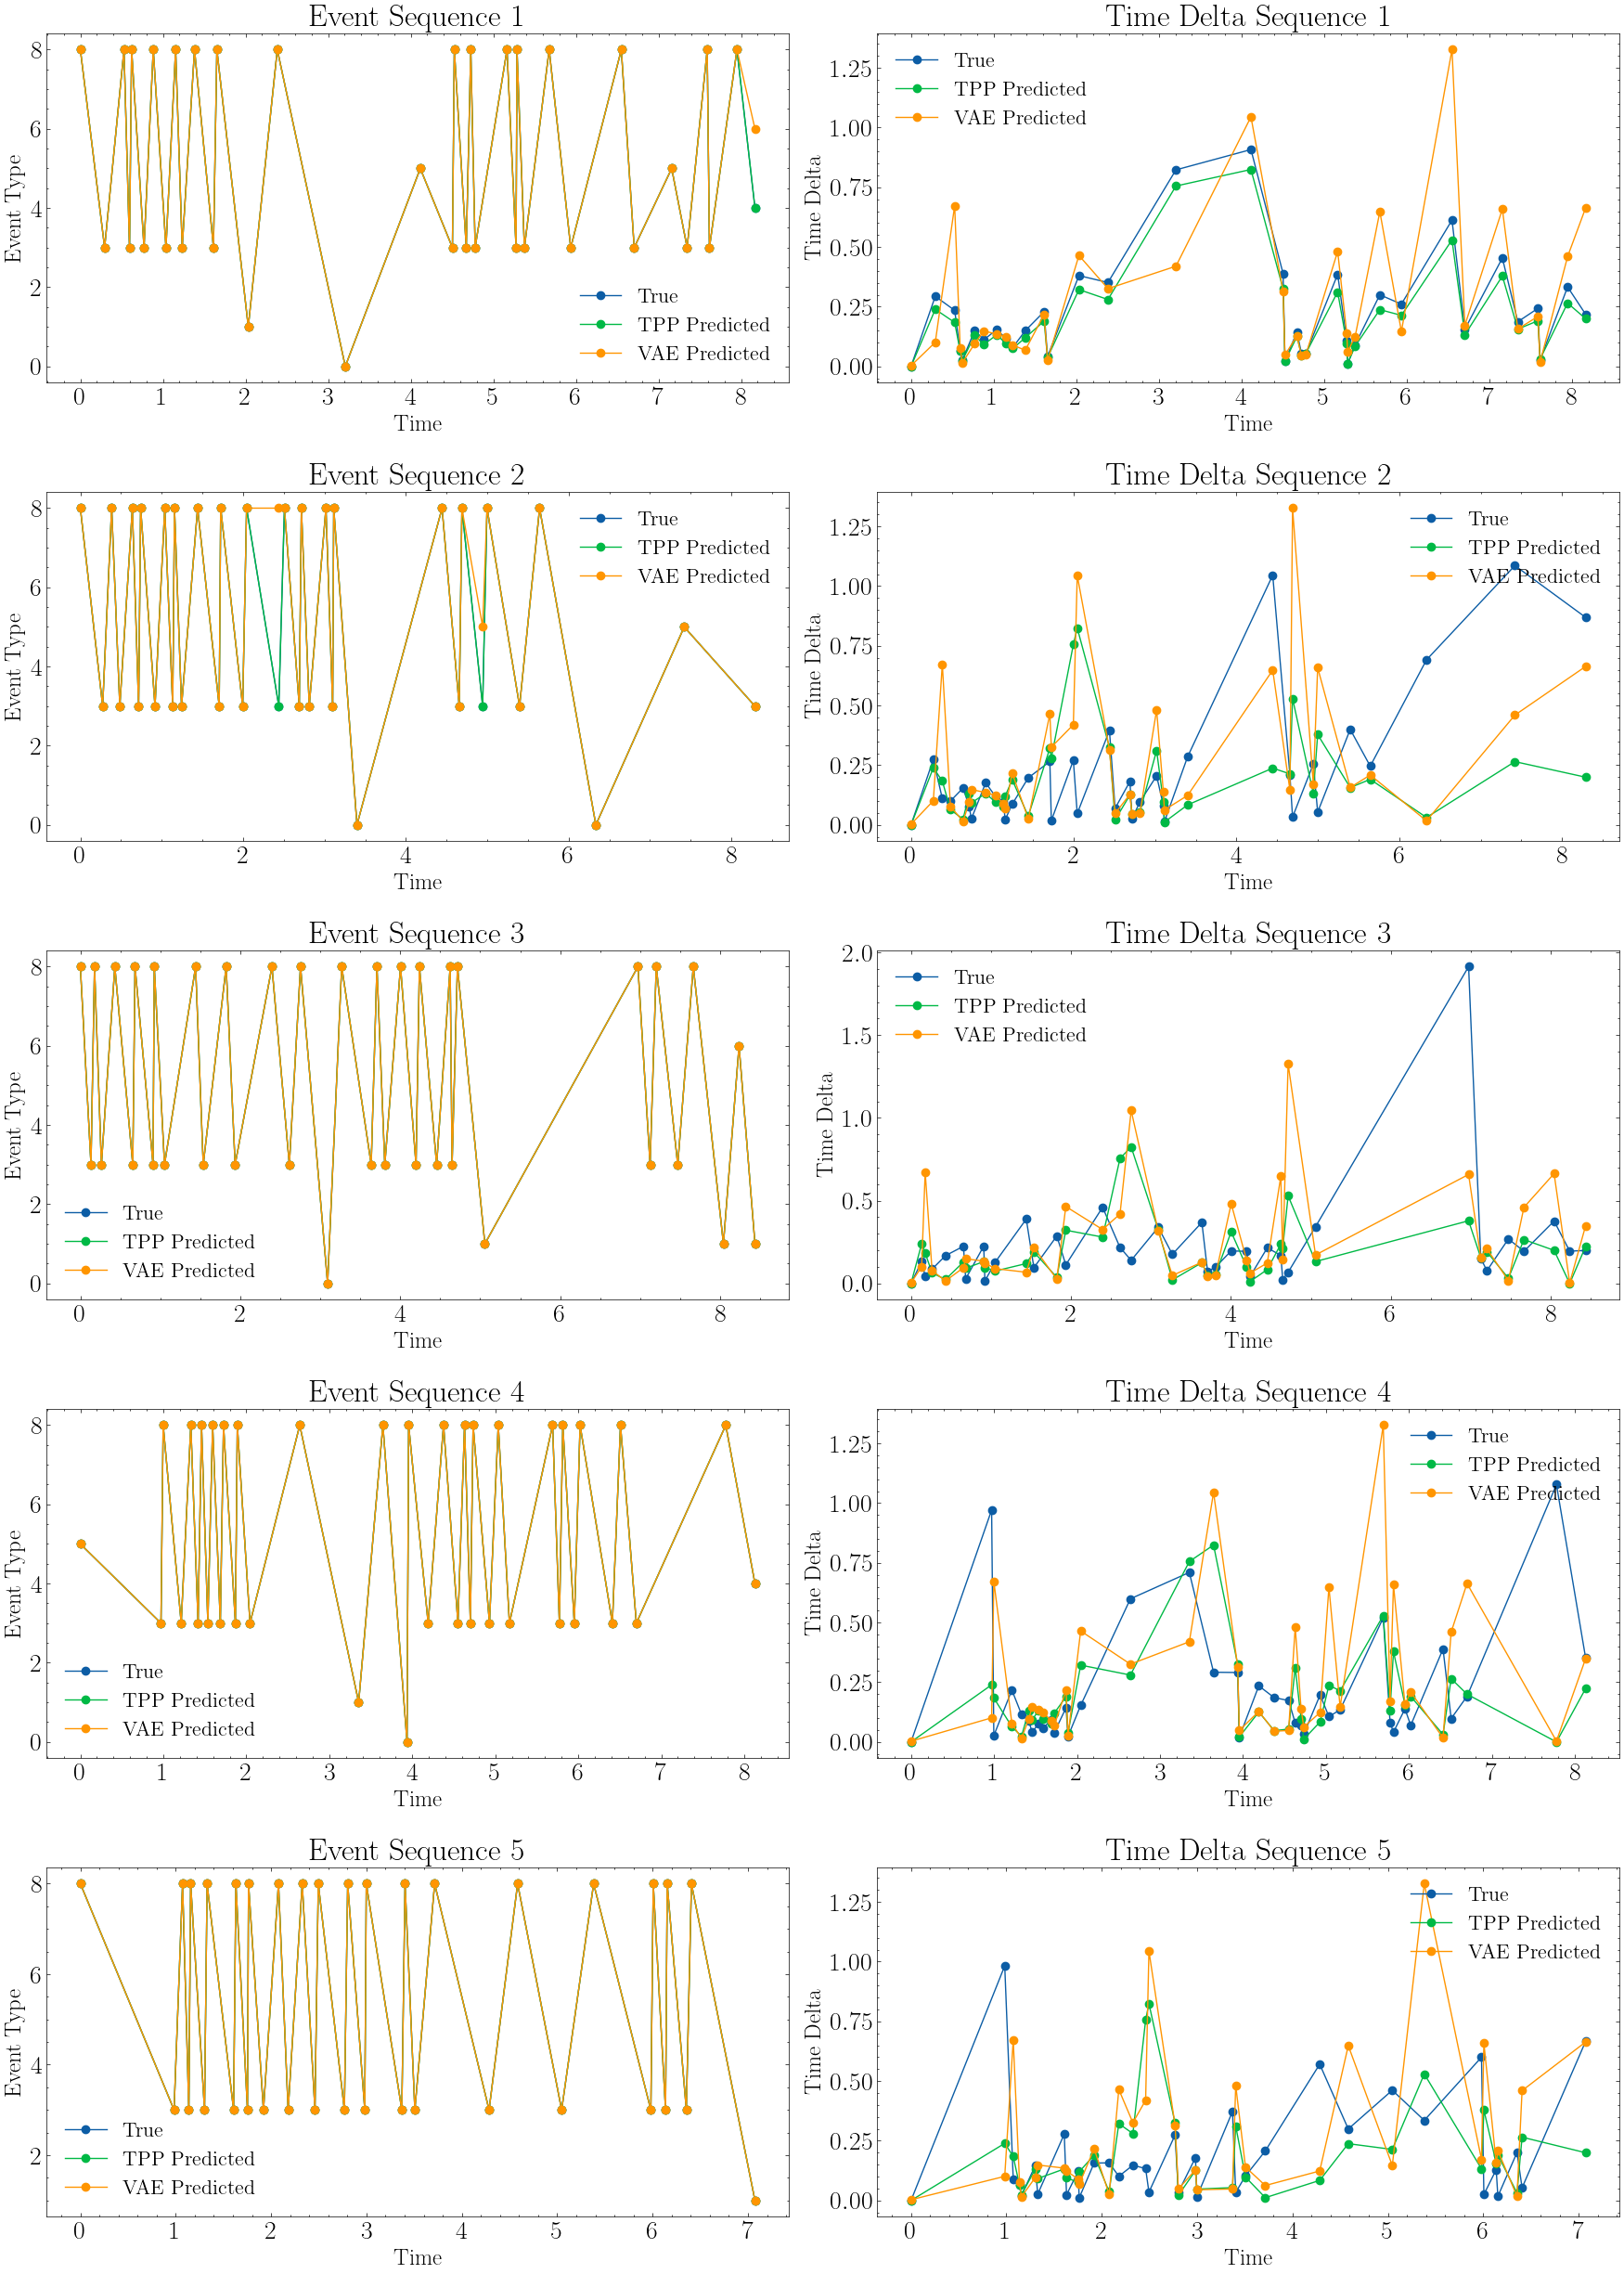

In [64]:
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}

    decoder_output_tpp = tpp_model(batch)
    decoder_output_vae = vae_model(batch)

    plot_event_sequence_both(
        batch["time_seqs"],
        batch["type_seqs"],
        batch["time_delta_seqs"],
        batch["sequence_length"],
        tpp_eval_metrics,
        vae_eval_metrics,
        decoder_output_tpp,
        decoder_output_vae,
        file_name="event_sequence_comparison.png",
    )
    break

In [65]:
# get and tabulate time mae, time rmse, mark accuracy in a table pandas
import pandas as pd
metric_keys = ['time_mae', 'time_rmse', 'event_accuracy']
tpp_df_metrics = {key: [tpp_eval_metrics[key]] for key in metric_keys}
tpp_df = pd.DataFrame.from_dict(tpp_df_metrics)

vae_df_metrics = {key: [vae_eval_metrics[key]] for key in metric_keys}
vae_df = pd.DataFrame.from_dict(vae_df_metrics)

df = pd.concat([tpp_df, vae_df], axis=0)
df.index = ['RMTPP', 'VAETPP']
# index column name
df.index.name = 'Architecture'
df.to_latex('metrics_table.tex', bold_rows=True)


In [ ]:
from sklearn.manifold import TSNE

def plot_latent_space(model, data_loader, device, file_name=None):
    """
    Plot latent space of the VAE model using mu from the forward pass, excluding padding tokens.

    Args:
        model (VAETPPModel): VAE model.
        data_loader (DataLoader): Data loader.
        device (str): Device to run the model on.
    """
    model.eval()
    mus = []
    event_types = []
    masks = []

    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            output = model(batch)
            mu = output.mu
            
            # Create mask for padding tokens
            sequence_lengths = batch["sequence_length"]
            batch_mask = torch.arange(batch["type_seqs"].size(1)).unsqueeze(0).to(device) < sequence_lengths.unsqueeze(1)
            
            # Reshape mu and event types if they have sequence dimension
            if len(mu.shape) > 2:
                mu = mu.reshape(-1, mu.shape[-1])
                batch_mask = batch_mask.reshape(-1)
            
            mus.append(mu)
            event_types.append(batch["type_seqs"].reshape(-1))
            masks.append(batch_mask)
            
            print("Shape of mu:", mu.shape)
            print("Shape of mask:", batch_mask.shape)
    
    # Concatenate all batches
    mus = torch.cat(mus, dim=0).cpu().numpy()
    event_types = torch.cat(event_types, dim=0).cpu().numpy()
    masks = torch.cat(masks, dim=0).cpu().numpy()
    
    print("Shape before masking:")
    print("mus:", mus.shape)
    print("event_types:", event_types.shape)
    print("masks:", masks.shape)
    
    # Apply mask to filter out padding tokens
    mus = mus[masks]
    event_types = event_types[masks]
    
    print("\nShape after masking:")
    print("mus:", mus.shape)
    print("event_types:", event_types.shape)
    
    # Reduce dimensionality using t-SNE    
    tsne = TSNE(n_components=2, random_state=0)
    mus = tsne.fit_transform(mus)
    
    # Make color discrete map using default rc colormap
    unique_event_types = np.unique(event_types)
    # colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = plt.cm.tab20.colors
    color_map = {event_type: colors[i % len(colors)] for i, event_type in enumerate(unique_event_types)}
    
    # Create visualization
    plt.figure(figsize=(10, 10))
    
    # Create list of colors for each point
    point_colors = [color_map[int(et)] for et in event_types]
    
    scatter = plt.scatter(mus[:, 0], mus[:, 1], c=point_colors, alpha=0.6)
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space of VAETPP Model (Excluding Padding)")
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=color_map[et], label=f'Event {et}',
                                markersize=10)
                      for et in unique_event_types]
    plt.legend(handles=legend_elements, title="Event Types", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(file_name) if file_name else plt.show()
    
plot_latent_space(vae_model, test_loader, device, file_name='vaetpp_latent_space.png')

Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([608, 32])
Shape of mask: torch.Size([608])
Shape before masking:
mus: (15200, 32)
event_types: (15200,)
masks: (15200,)

Shape after ma

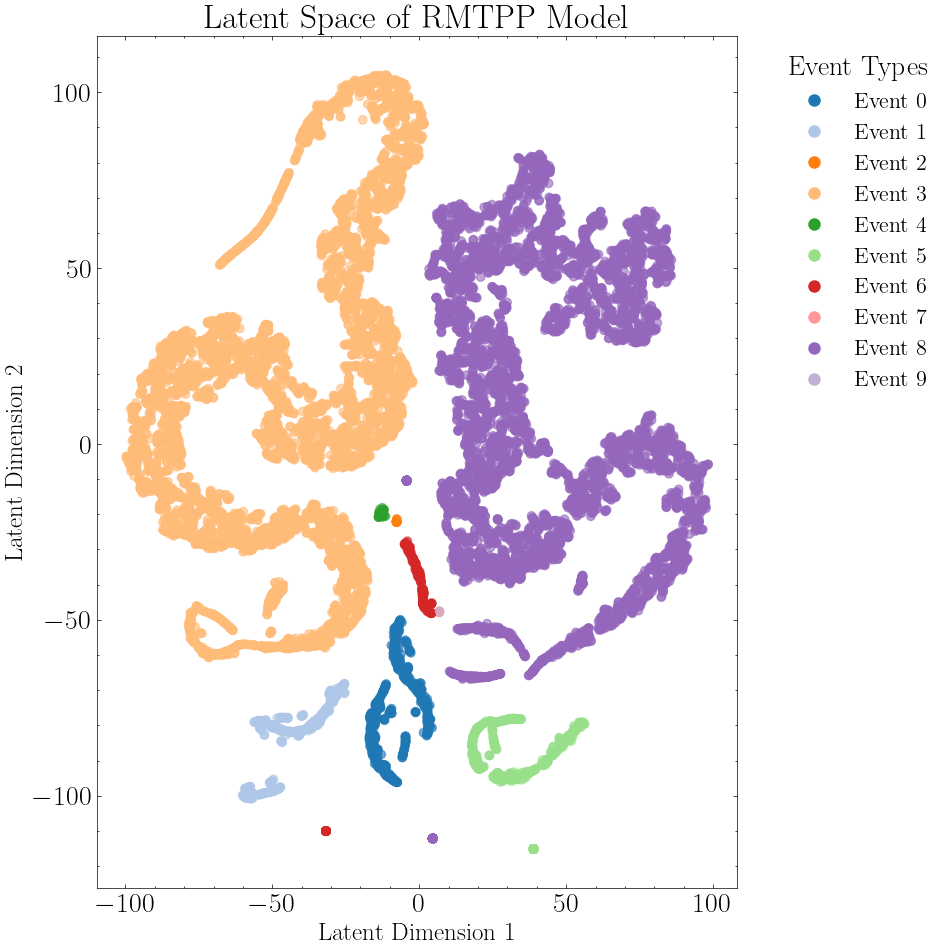

In [ ]:
def plot_latent_space_tpp(model, data_loader, device, file_name=None):
    """
    Plot latent space for TPP models using hidden states, excluding padding tokens.

    Args:
        model (nn.Module): TPP model (e.g., RMTPPModel).
        data_loader (torch.utils.data.DataLoader): Data loader for input batches.
        device (torch.device): Device to run the model on.
    """
    model.eval()
    latent_representations = []
    event_types = []
    masks = []

    with torch.no_grad():
        for batch in data_loader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass to get hidden states
            hidden_states = model.encoder(batch)  # Extract hidden states from encoder
            
            # Create mask to exclude padding tokens
            sequence_lengths = batch["sequence_length"]
            batch_mask = (
                torch.arange(batch["type_seqs"].size(1)).unsqueeze(0).to(device)
                < sequence_lengths.unsqueeze(1)
            )
            
            # Reshape hidden states and masks if they have a sequence dimension
            if len(hidden_states.shape) > 2:  # If hidden states are [batch_size, seq_len, hidden_dim]
                hidden_states = hidden_states.reshape(-1, hidden_states.shape[-1])
                batch_mask = batch_mask.reshape(-1)
            
            latent_representations.append(hidden_states)
            event_types.append(batch["type_seqs"].reshape(-1))
            masks.append(batch_mask)
    
    # Concatenate all batches
    latent_representations = torch.cat(latent_representations, dim=0).cpu().numpy()
    event_types = torch.cat(event_types, dim=0).cpu().numpy()
    masks = torch.cat(masks, dim=0).cpu().numpy()
    
    # Apply mask to exclude padding tokens
    latent_representations = latent_representations[masks]
    event_types = event_types[masks]
    
    # Reduce dimensionality using t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    latent_representations = tsne.fit_transform(latent_representations)
    
    # Create discrete color mapping for event types
    unique_event_types = np.unique(event_types)
    colors = plt.cm.tab20.colors  # Use tab20 colormap for discrete categories
    color_map = {event_type: colors[i % len(colors)] for i, event_type in enumerate(unique_event_types)}
    
    # Create a scatter plot of the latent space
    plt.figure(figsize=(10, 10))
    point_colors = [color_map[int(et)] for et in event_types]
    plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c=point_colors, alpha=0.6)
    
    # Add axis labels and title
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space of RMTPP Model")
    
    # Add legend for event types
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[et],
                   label=f'Event {et}', markersize=10)
        for et in unique_event_types
    ]
    plt.legend(handles=legend_elements, title="Event Types", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    if file_name:
        plt.savefig(file_name)
    plt.show()


plot_latent_space_tpp(tpp_model, test_loader, device, file_name='latent_space_tpp.png')

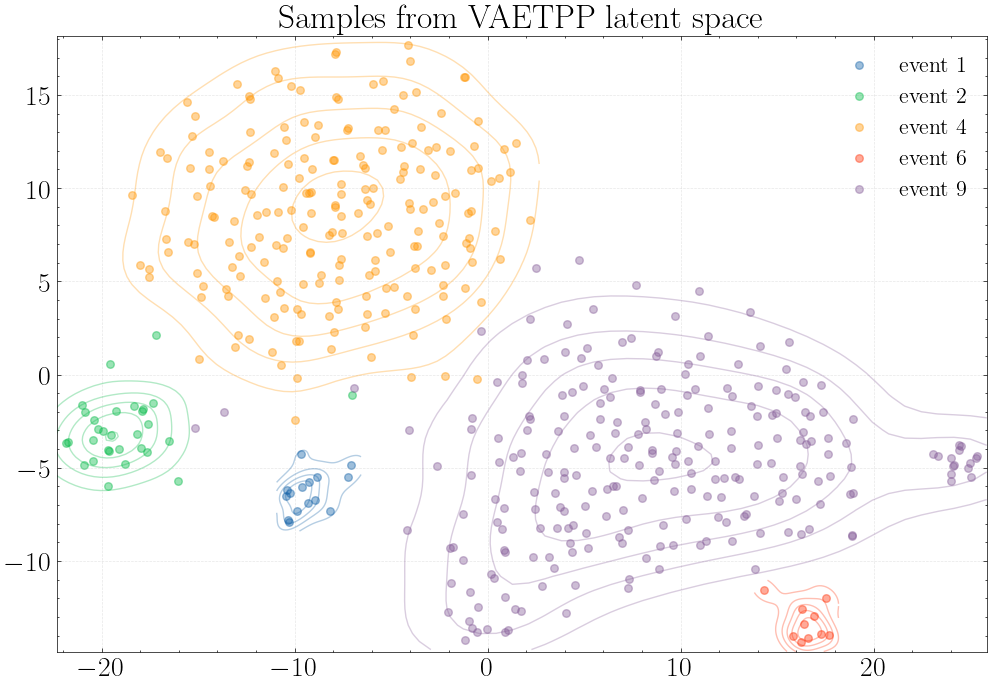

In [70]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.manifold import TSNE

def visualize_vae_latent_space(model, data_loader, device, max_samples=100):
    model.eval()
    
    batch = next(iter(data_loader))
    batch = {k: v.to(device) for k, v in batch.items()}
    sequence_lengths = batch["sequence_length"].to(device)
    
    # identify the padding tokens
    mask = torch.arange(batch["type_seqs"].size(1)).unsqueeze(0).to(device) < sequence_lengths.unsqueeze(1)
    mask = mask.cpu().numpy()
    
    with torch.no_grad():
        output = model(batch)
        mu = output.mu.cpu().numpy()
        logvar = output.logvar.cpu().numpy()
        event_types = batch["type_seqs"].cpu().numpy()
        
        mu = mu[mask].reshape(-1, mu.shape[-1])
        logvar = logvar[mask].reshape(-1, logvar.shape[-1])
        event_types = event_types[mask].reshape(-1)
        
        if len(mu) > max_samples:
            idx = np.random.choice(len(mu), max_samples, replace=False)
            mu = mu[idx]
            logvar = logvar[idx]
            event_types = event_types[idx]
    
    std = np.exp(0.5 * logvar)
    n_samples_per_point = 5
    samples = []
    sample_types = []
    
    for i in range(len(mu)):
        for _ in range(n_samples_per_point):
            sample = mu[i] + np.random.randn(*mu[i].shape) * std[i]
            samples.append(sample)
            sample_types.append(event_types[i])
    
    samples = np.stack(samples)
    sample_types = np.array(sample_types)
    
    tsne = TSNE(n_components=2, random_state=42)
    samples_2d = tsne.fit_transform(samples)
    
    plt.figure(figsize=(12, 8))
    
    # Get default color cycle
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    for idx, event_type in enumerate(np.unique(event_types)):
        mask = sample_types == event_type
        points = samples_2d[mask]
        
        kde = gaussian_kde(points.T)
        x_min, x_max = points[:, 0].min() - 0.5, points[:, 0].max() + 0.5
        y_min, y_max = points[:, 1].min() - 0.5, points[:, 1].max() + 0.5
        
        x = np.linspace(x_min, x_max, 50)
        y = np.linspace(y_min, y_max, 50)
        X, Y = np.meshgrid(x, y)
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = kde(positions).reshape(X.shape)
        
        color = colors[idx % len(colors)]
        label = f'event {event_type + 1}'
        
        plt.contour(X, Y, Z, levels=5, colors=color, alpha=0.3)
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.4, label=label, s=30)
    
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.title('Samples from VAETPP latent space')
    
    return plt.gcf()

# Usage
fig = visualize_vae_latent_space(vae_model, test_loader, device, max_samples=100)
plt.savefig('vae_latent_space_samples.png')
plt.show()